In [ ]:
pip install tensorflow keras matplotlib numpy opencv-python


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.8/47.8 kB 357.6 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 1.1 MB/s eta 0:00:00a 0:00:01
  Using cached wheel-0.43.0-py3-none-any.whl.metadata (2.2 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.7/259.7 MB 3.4 MB/s eta 0:00:0000:0100:02
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 5.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 6.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 6.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.7/133.7 kB 2.5 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 263.3/263.3 kB 4.1 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 5.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 5.8 MB/s eta 0

In [ ]:
import os
import shutil
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

2024-07-23 14:48:56.988558: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [14]:
import os
import csv

def create_labels(image_folder, label):
    # Check if the file is empty to write header
    file_exists = os.path.isfile('labels.csv')
    
    with open('labels.csv', 'a', newline='') as file:
        writer = csv.writer(file)
        
        # Write the header if the file is empty
        if not file_exists or os.path.getsize('labels.csv') == 0:
            writer.writerow(['image', 'label'])
        
        for filename in os.listdir(image_folder):
            if filename.lower().endswith(('.jpg', '.png', '.jpeg')):
                writer.writerow([filename, label])

# Paths to your image folders
solar_farm_folder = '/Users/macbookpro/Desktop/SolarProject/SolarFarm_Images'
non_solar_farm_folder = '/Users/macbookpro/Desktop/SolarProject/Non_SolarFarms'

# Create labels
create_labels(solar_farm_folder, 1)  # Label 1 for solar farms
create_labels(non_solar_farm_folder, 0)  # Label 0 for non-solar farms


In [4]:
base_dir = '/Users/macbookpro/Desktop/SolarProject/dataset'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Create directories if they don't exist
os.makedirs(os.path.join(train_dir, 'solar_farm'), exist_ok=True)
os.makedirs(os.path.join(train_dir, 'non_solar_farm'), exist_ok=True)
os.makedirs(os.path.join(validation_dir, 'solar_farm'), exist_ok=True)
os.makedirs(os.path.join(validation_dir, 'non_solar_farm'), exist_ok=True)


In [20]:
df = pd.read_csv('labels.csv')
# Define function to split images into train and validation
# Paths to your image folders
solar_farm_folder = '/Users/macbookpro/Desktop/SolarProject/SolarFarm_Images'
non_solar_farm_folder = '/Users/macbookpro/Desktop/SolarProject/Non_SolarFarms'
def split_and_copy_images(df, img_folder, output_train_folder, output_validation_folder, test_size=0.2):
    # Split dataframe
    train_df, val_df = train_test_split(df, test_size=test_size, stratify=df['label'])
    
    # Copy images to respective directories
    for index, row in train_df.iterrows():
        src_path = os.path.join(img_folder, row['image'])
        # dest_path = os.path.join(output_train_folder, 'solar_farm' if row['label'] == 1 else 'non_solar_farm', row['image'])
        dest_path = output_train_folder
        shutil.copy(src_path, dest_path)
    
    for index, row in val_df.iterrows():
        src_path = os.path.join(img_folder, row['image'])
        #dest_path = os.path.join(output_validation_folder, 'solar_farm' if row['label'] == 1 else 'non_solar_farm', row['image'])
        dest_path = output_validation_folder
        shutil.copy(src_path, dest_path)

# Split and copy images
split_and_copy_images(df[df['label'] == 1], solar_farm_folder, os.path.join(train_dir, 'solar_farm'), os.path.join(validation_dir, 'solar_farm'))
split_and_copy_images(df[df['label'] == 0], non_solar_farm_folder, os.path.join(train_dir, 'non_solar_farm'), os.path.join(validation_dir, 'non_solar_farm'))

In [137]:
image_size = (150, 150)
batch_size = 24

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    # width_shift_range=0.2,
    # height_shift_range=0.2,
    # shear_range=0.2,
    zoom_range=(1.0, 1.2),
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary'
)

Found 83 images belonging to 2 classes.
Found 22 images belonging to 2 classes.


In [138]:
from tensorflow.keras.optimizers import Adam,RMSprop
from tensorflow.keras.layers import Dropout
def create_cnn_model():
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Flatten())
    layers.Dense(1024, activation='relu'),
    model.add(layers.Dense(1, activation='sigmoid'))
    
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    return model

model = create_cnn_model()

In [139]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=15,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size
)

Epoch 1/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.4822 - loss: 0.6971 - val_accuracy: 0.5000 - val_loss: 0.7691
Epoch 2/15
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step - accuracy: 0.3750 - loss: 0.8592

2024-07-23 19:16:12.244887: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 499ms/step - accuracy: 0.3750 - loss: 0.8592 - val_accuracy: 0.5000 - val_loss: 0.6969
Epoch 3/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 750ms/step - accuracy: 0.5514 - loss: 0.6768 - val_accuracy: 0.5000 - val_loss: 0.6826
Epoch 4/15
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step - accuracy: 0.4583 - loss: 0.6888

2024-07-23 19:16:16.151304: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 520ms/step - accuracy: 0.4583 - loss: 0.6888 - val_accuracy: 0.7273 - val_loss: 0.6853
Epoch 5/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 752ms/step - accuracy: 0.7565 - loss: 0.6831 - val_accuracy: 0.7273 - val_loss: 0.6804
Epoch 6/15
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step - accuracy: 0.7083 - loss: 0.6870

2024-07-23 19:16:20.103827: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 498ms/step - accuracy: 0.7083 - loss: 0.6870 - val_accuracy: 0.7727 - val_loss: 0.6773
Epoch 7/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 934ms/step - accuracy: 0.6739 - loss: 0.6795 - val_accuracy: 0.6818 - val_loss: 0.6629
Epoch 8/15
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step - accuracy: 0.4167 - loss: 0.6837

2024-07-23 19:16:24.245133: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 526ms/step - accuracy: 0.4167 - loss: 0.6837 - val_accuracy: 0.7727 - val_loss: 0.6526
Epoch 9/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 737ms/step - accuracy: 0.6521 - loss: 0.6778 - val_accuracy: 0.7727 - val_loss: 0.6292
Epoch 10/15
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step - accuracy: 0.7917 - loss: 0.6147

2024-07-23 19:16:28.355484: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 491ms/step - accuracy: 0.7917 - loss: 0.6147 - val_accuracy: 0.7273 - val_loss: 0.6007
Epoch 11/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 816ms/step - accuracy: 0.6337 - loss: 0.6311 - val_accuracy: 0.7727 - val_loss: 0.5368
Epoch 12/15
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - accuracy: 0.8182 - loss: 0.5612

2024-07-23 19:16:32.212220: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 494ms/step - accuracy: 0.8182 - loss: 0.5612 - val_accuracy: 0.5000 - val_loss: 0.6550
Epoch 13/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 877ms/step - accuracy: 0.6027 - loss: 0.6510 - val_accuracy: 0.7727 - val_loss: 0.4779
Epoch 14/15
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step - accuracy: 0.7500 - loss: 0.5356

2024-07-23 19:16:36.253568: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 552ms/step - accuracy: 0.7500 - loss: 0.5356 - val_accuracy: 0.8182 - val_loss: 0.4650
Epoch 15/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 895ms/step - accuracy: 0.6342 - loss: 0.6252 - val_accuracy: 0.7727 - val_loss: 0.4330


In [140]:
test_loss, test_acc = model.evaluate(validation_generator)
print(f'Test accuracy: {test_acc}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 960ms/step - accuracy: 0.7727 - loss: 0.4330
Test accuracy: 0.7727272510528564


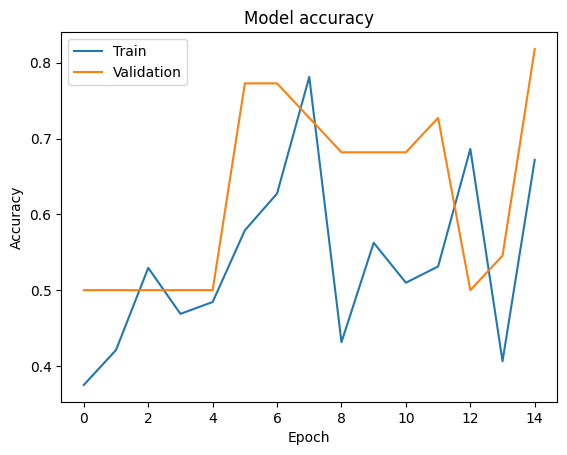

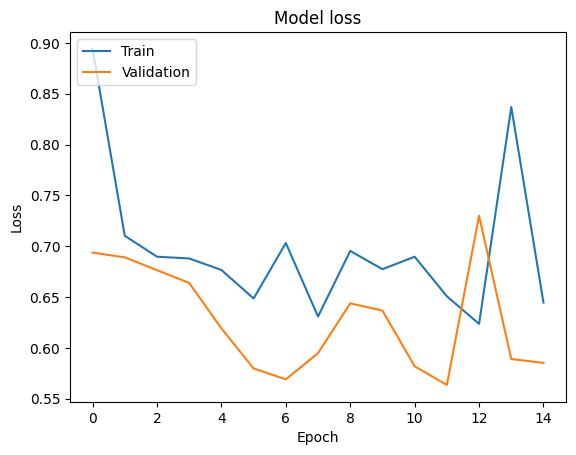

In [31]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 998ms/step
                precision    recall  f1-score   support

Non-Solar Farm       0.50      0.64      0.56        11
    Solar Farm       0.50      0.36      0.42        11

      accuracy                           0.50        22
     macro avg       0.50      0.50      0.49        22
  weighted avg       0.50      0.50      0.49        22



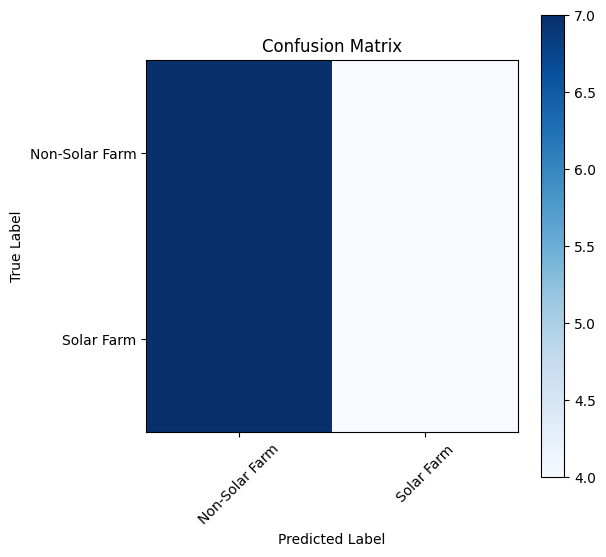

In [141]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Get predictions
y_pred = model.predict(validation_generator)
y_pred = np.round(y_pred)  # Convert probabilities to binary predictions

# Get true labels
y_true = validation_generator.classes

# Print classification report
print(classification_report(y_true, y_pred, target_names=['Non-Solar Farm', 'Solar Farm']))

# Plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 6))
plt.imshow(cm, interpolation='nearest', cmap='Blues')
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Non-Solar Farm', 'Solar Farm'], rotation=45)
plt.yticks(tick_marks, ['Non-Solar Farm', 'Solar Farm'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [116]:
model.save('solar_farm_model.h5')